In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


# Data

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([ # Augmentation
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))
        ])

cuda_num = 0 # CUDA DEVICE
batch_size = 128


In [3]:
mnist_dataset = MNIST('./MNIST', train=True, transform=image_transforms, download=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 9706385.69it/s] 


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7675560.37it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5117488.30it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2439248.24it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



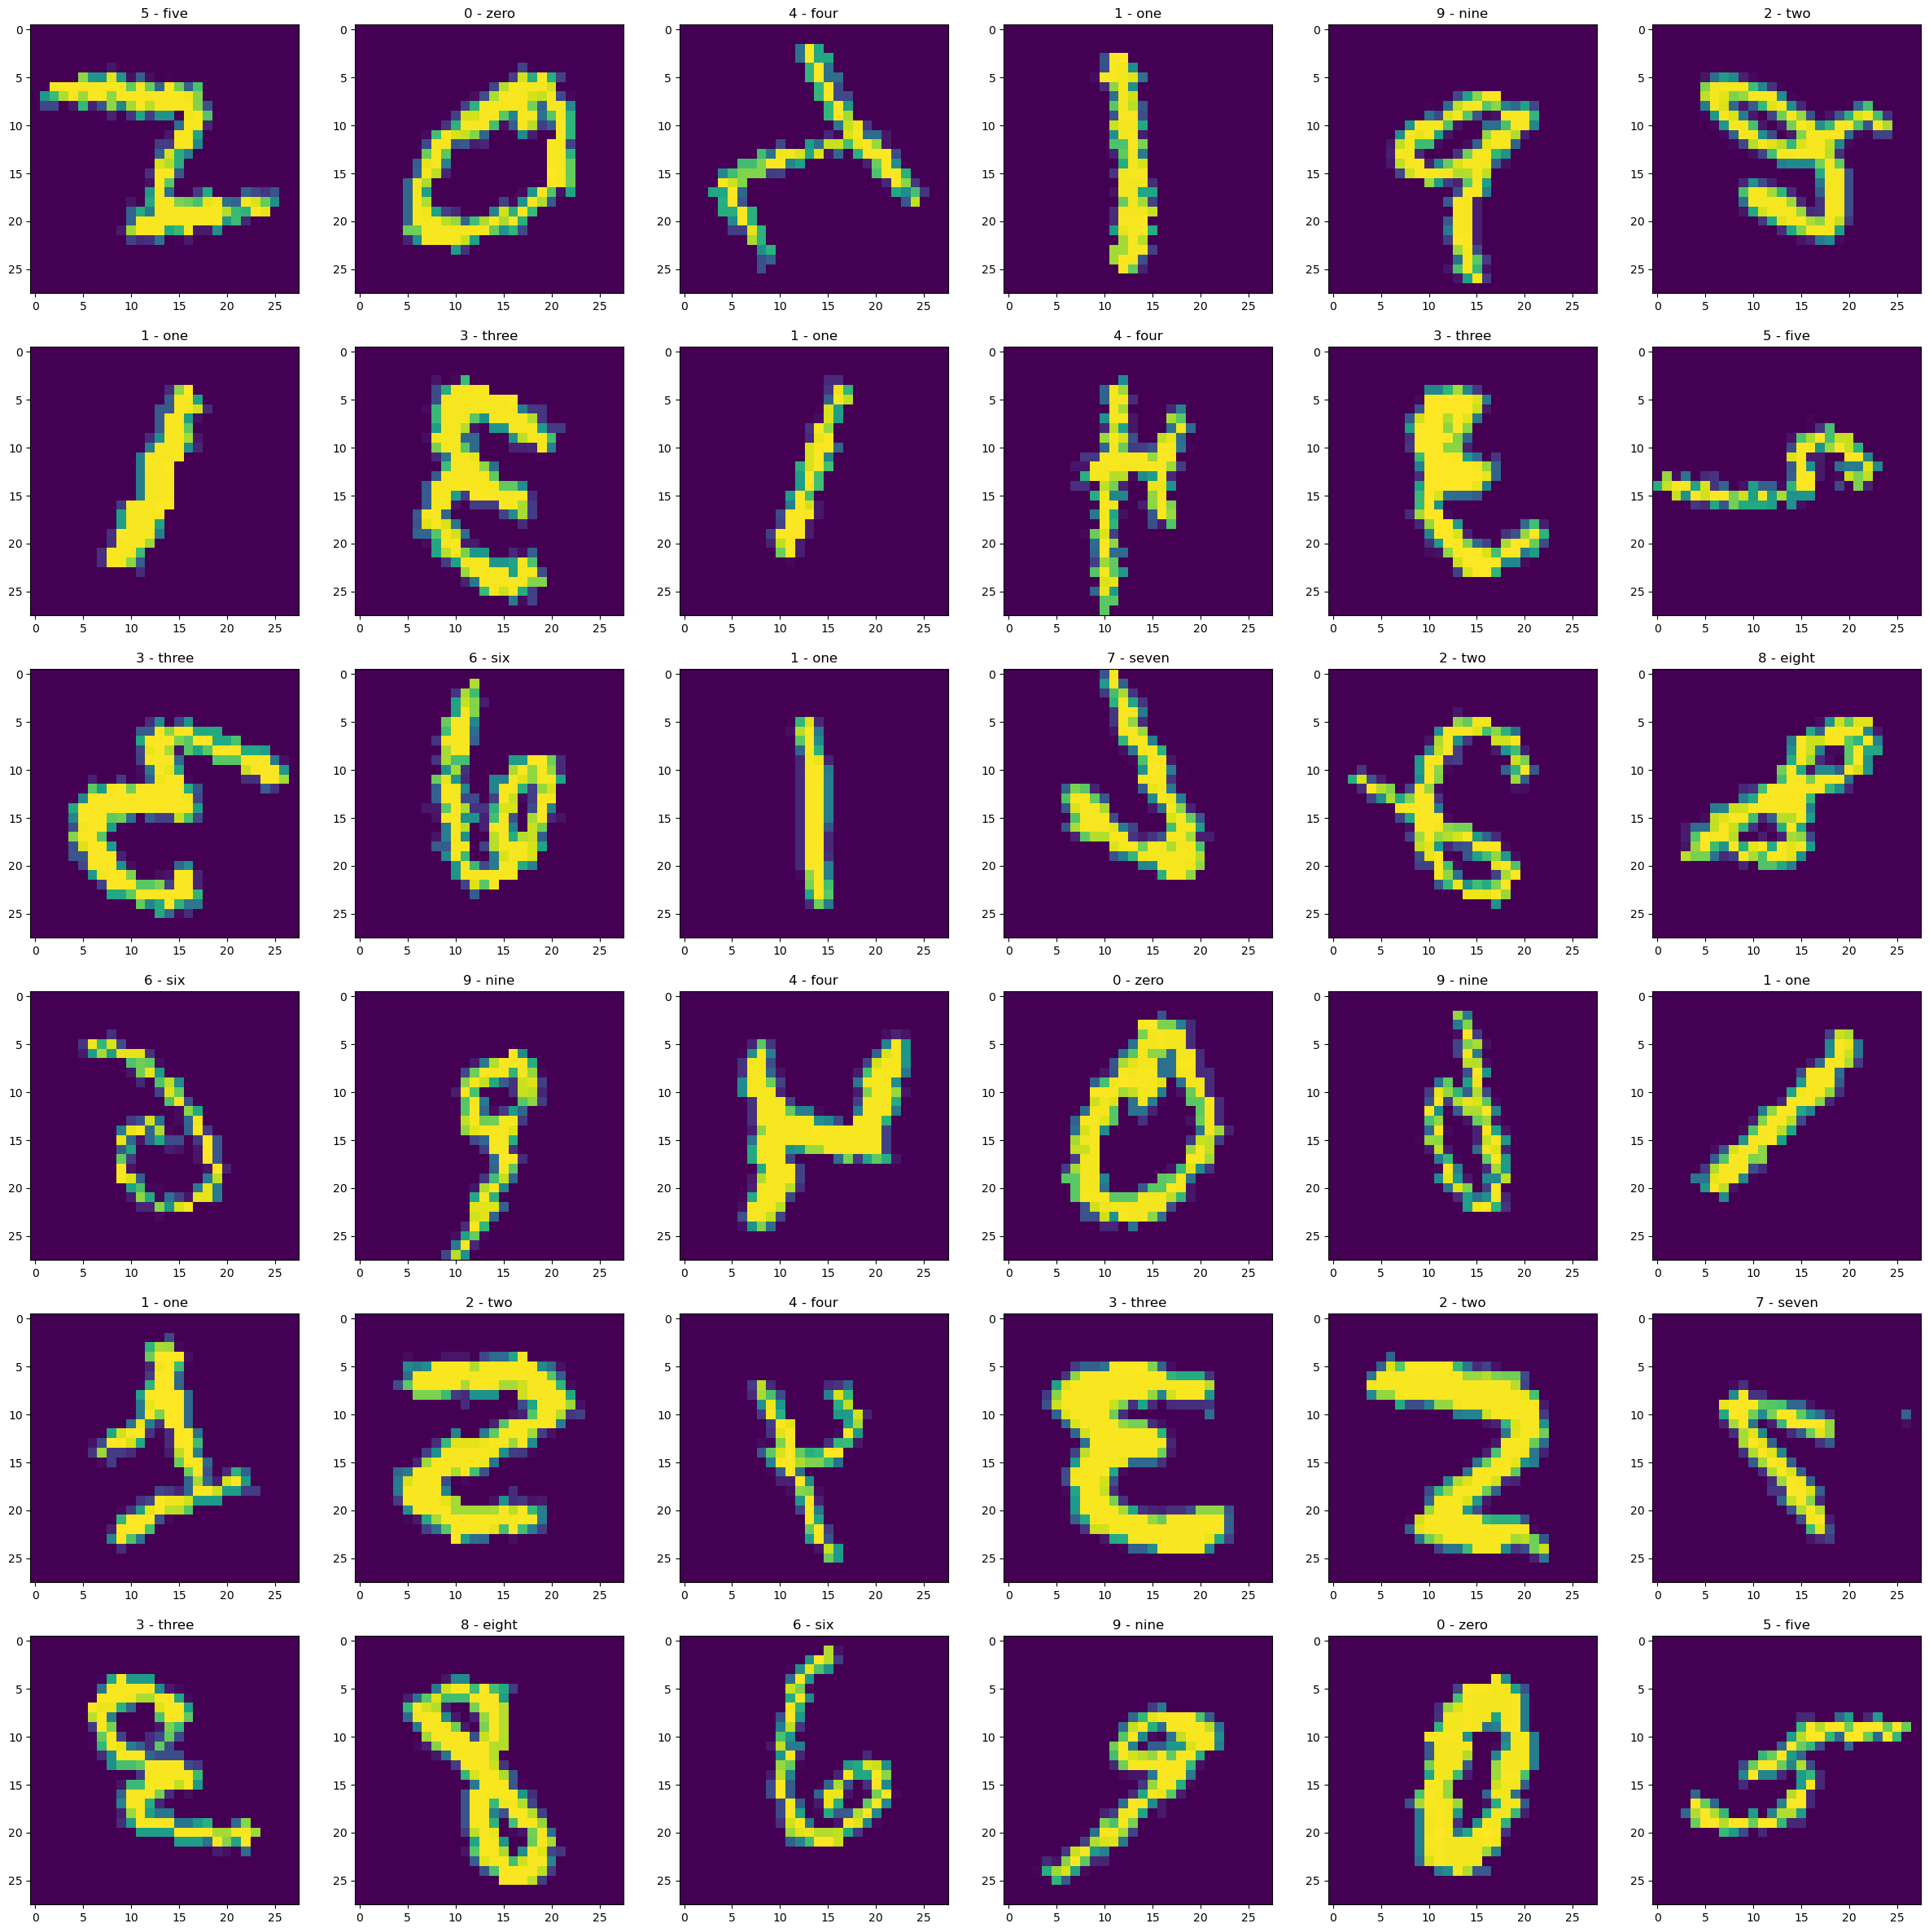

In [22]:
def process_image(image):
    ### YOUR CODE HERE
    # return ??? # numpy image with pixel values in [0, 1]
    #image is a tupe of (tensor, label)
    if type(image) == torch.Tensor:
        result = image.numpy()
    else:
        result = image[0].numpy()
    return result.transpose(1, 2, 0).squeeze()

labels2name = {i: j for j, i in mnist_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(mnist_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()

## Define dataset for zeros only

In [8]:
class OnlyZerosDataset(torch.utils.data.Dataset):
    ### MNIST subdataset with zero class only
    def __init__(self, mnist, transform=None):
        # ??? # YOUR CODE HERE
        # self.mnist = ??? # YOUR CODE HERE
        self.mnist = []
        for image, label in mnist:
            if label == 0:
                self.mnist.append((image, label))
        self.transform = transform

    def __len__(self):
        # return ??? # YOUR CODE HERE
        #len of mnist should be 5923
        return len(self.mnist)

    def __getitem__(self, index): # YOUR CODE HERE
        # return ???
        return self.mnist[index]

zeros_dataset = OnlyZerosDataset(mnist_dataset)
zeros_loader = DataLoader(zeros_dataset, batch_size=batch_size, drop_last=True)
assert(len(zeros_dataset) == 5923)
#print(len(zeros_dataset))

5923


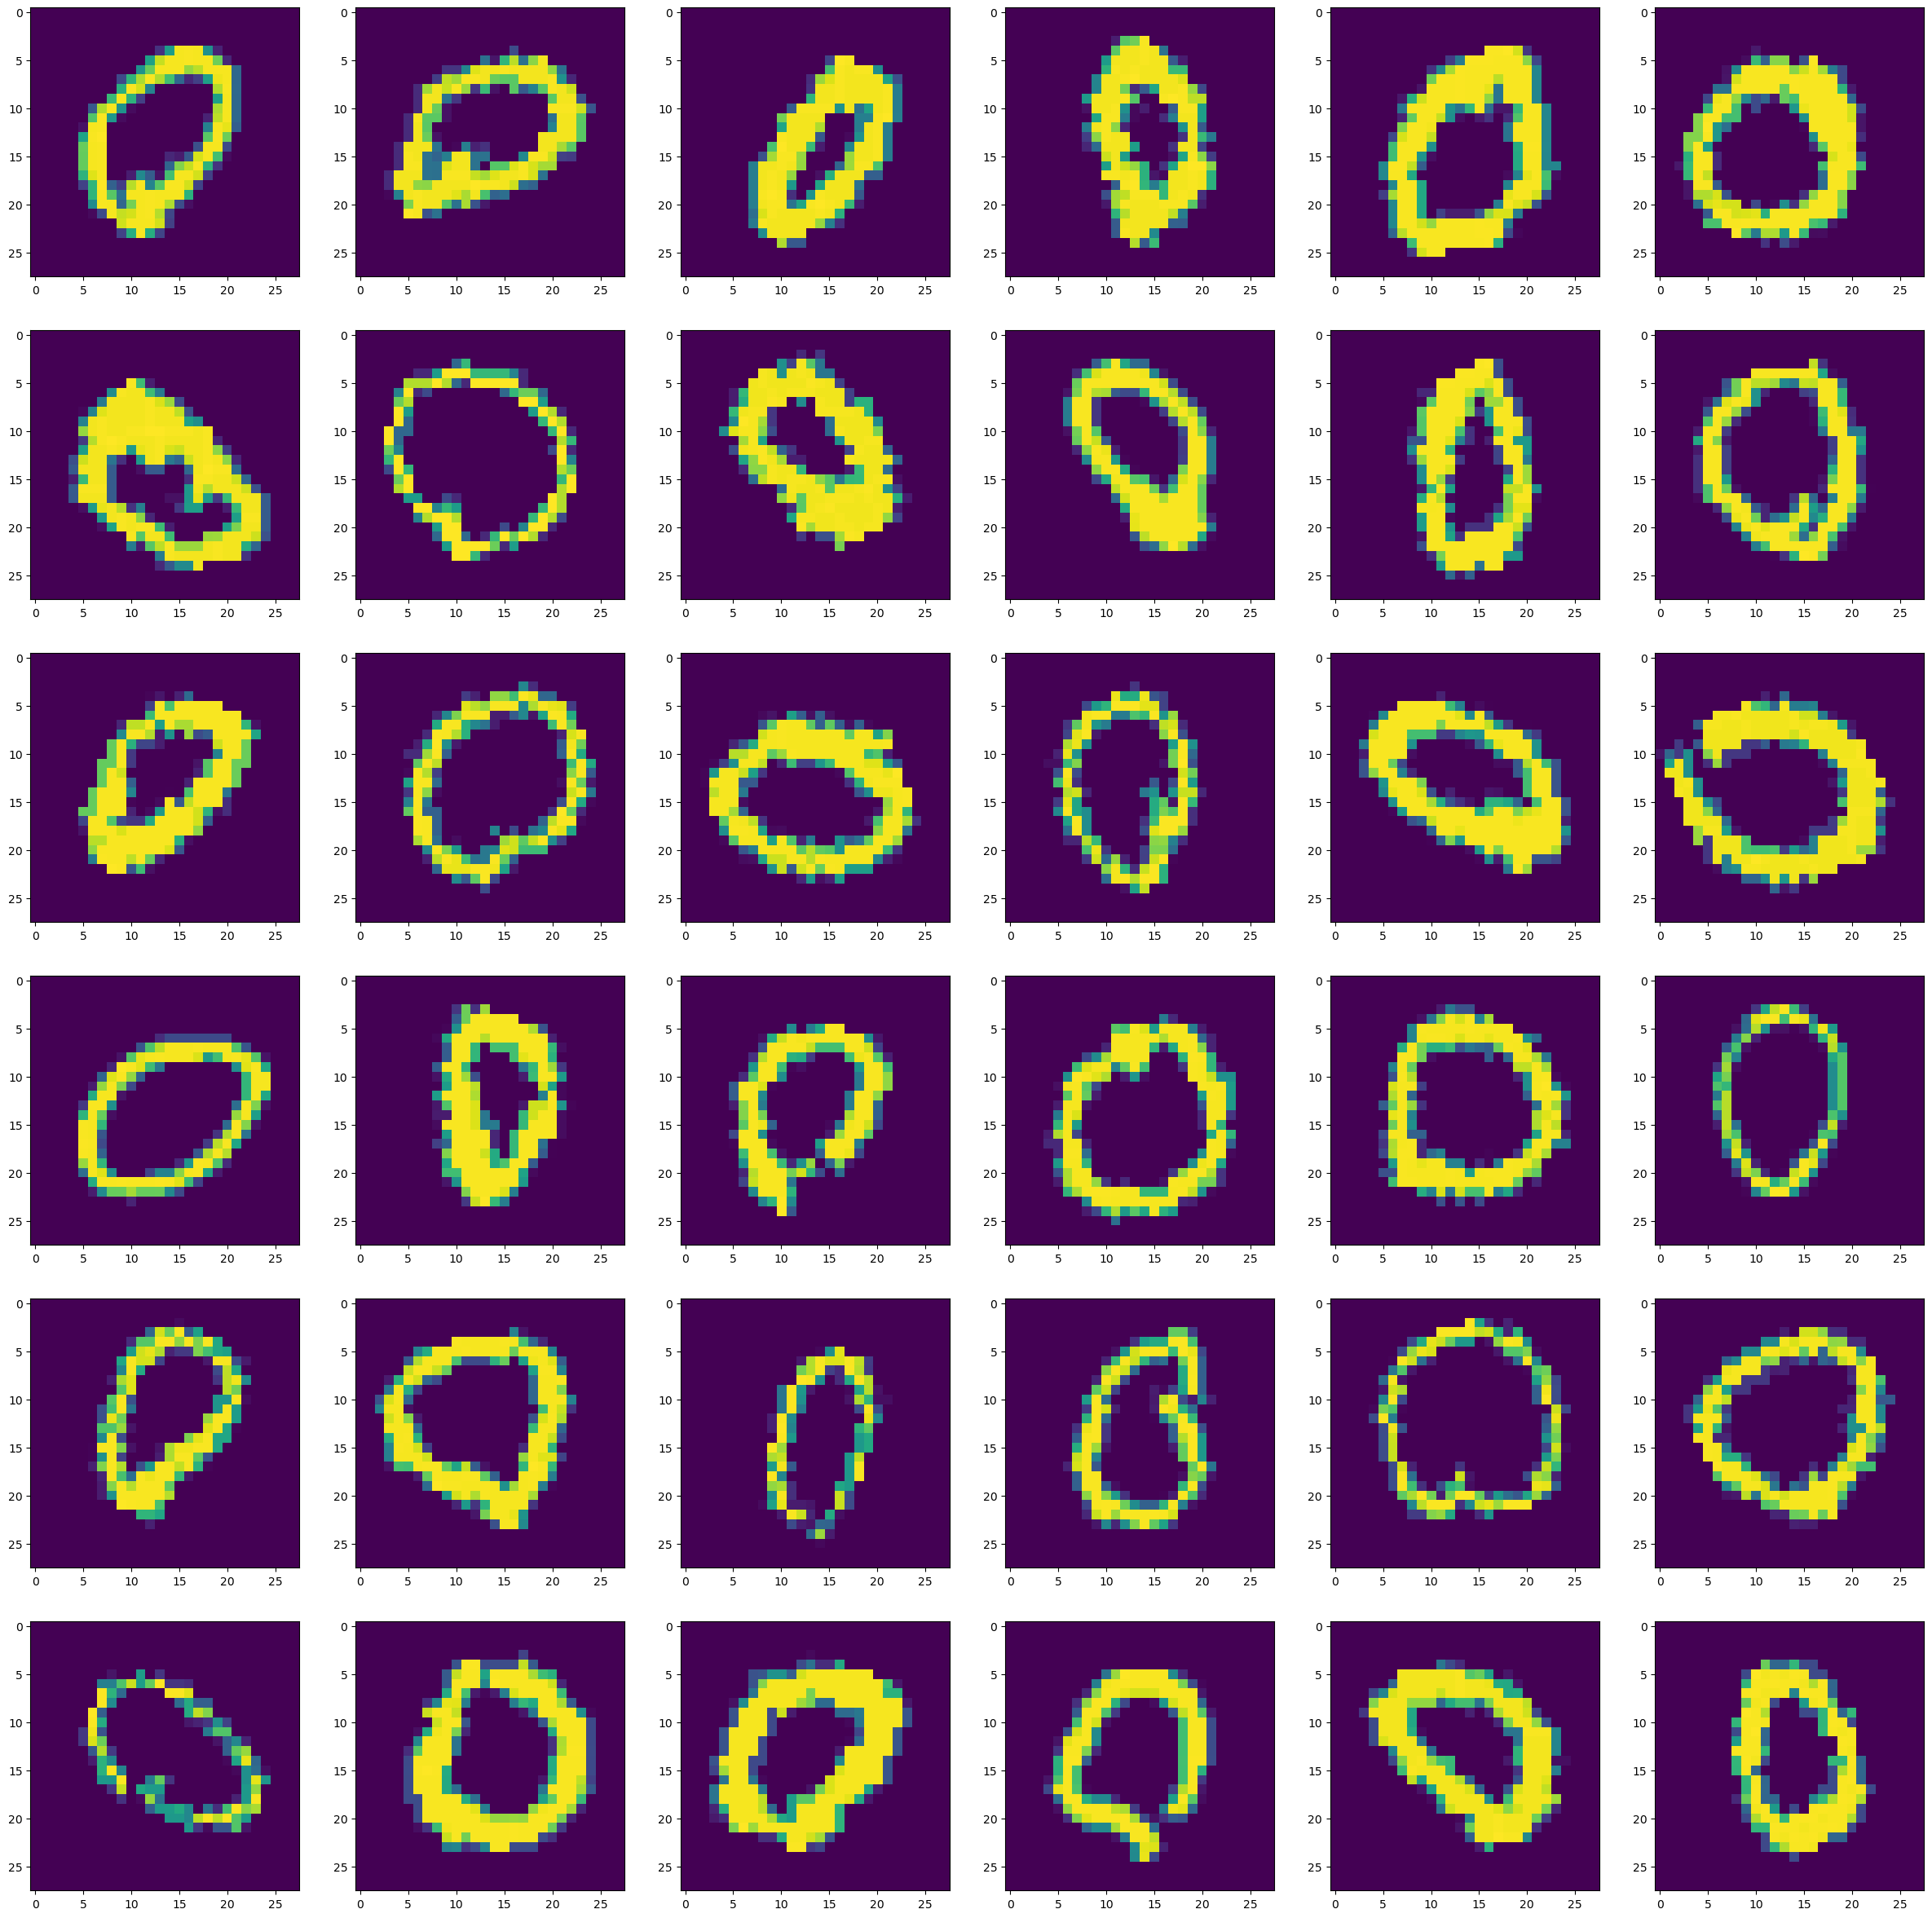

In [23]:
plt.figure(figsize=(30, 30))
for ind, image in enumerate(zeros_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()
    
    

![image](https://camo.githubusercontent.com/e43f336d6b83baf979de8ea558f34ccbe6713e1d/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f47414e2e706e67)

***Generator*** takes noise as input and generates images in output

***Discriminator*** is standard binary classifier which takes image samples as input and returns determines whether these images are fake (generated, 1st class) or not (real, 2nd class)

In [52]:
class Generator(nn.Module):
    # https://github.com/AKASHKADEL/dcgan-mnist/blob/master/networks.py
    # Define generator which takes random noise as input and generates image as output 
    def __init__(self, nc=1, nz=100, ngf=32):
      self.nz = nz
      super(Generator, self).__init__()
      # self.network = ??? # YOUR CODE HERE
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )

  
    def forward(self, size):
      output = self.network(torch.randn(size, self.nz, 1, 1, device=self.device))
      return output
    
    # def forward(self, noise):
    #   output = self.network(noise)
    #   return output
    
    @property
    def device(self):
      return next(self.parameters()).device

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        # Define binary classifier which discriminates real image from generated
        #self.network = ??? # YOUR CODE HERE
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        # return ??? # YOUR CODE HERE
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [53]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
discriminator = Discriminator().to(device)


# Weights initialization is very important! Use it to initialize weights for your networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

[model.apply(weights_init) for model in [generator, discriminator]] # initialize weights

optimizators = {
    'G': torch.optim.AdamW(generator.parameters(), lr=2e-4),
    'D': torch.optim.AdamW(discriminator.parameters(), lr=2e-4),
}

losses = {
    'D': [],
    'G': []
}

steps_ratio = 1 # ratio between gradient steps of generator and generator

In [ ]:
"""
for epoch in tqdm(range(300)):
    for batch_idx, images in enumerate(zeros_loader):
        # train D
        
        # YOUR CODE HERE. Fit discriminator on real and generated images
        # Hint: use torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1) # gradient clipping for stable convergence
        

        discriminator.zero_grad()
        real_images = images[0].to(device)
        real_labels = torch.ones(real_images.size(0), device=device)
        fake_labels = torch.zeros(real_images.size(0), device=device)
        real_output = discriminator(real_images)
        real_loss = nn.BCELoss()(real_output, real_labels)
        real_loss.backward()
        fake_images = generator(real_images.size(0)).detach()
        fake_output = discriminator(fake_images)
        fake_loss = nn.BCELoss()(fake_output, fake_labels)
        fake_loss.backward()
        loss = real_loss + fake_loss
        optimizators['D'].step()

        
        losses['D'].append(loss.item())
        # don't forget to use item
        
        if batch_idx % steps_ratio == 0:
          # train G
          # YOUR CODE HERE. Fit generator to "fool" discriminator (Make the discriminator to classify generated images as real ones)
          # Hint: use torch.nn.utils.clip_grad_norm_(generator.parameters(), 1) # gradient clipping for stable convergence
          generator.zero_grad()
          fake_images = generator(real_images.size(0))
          fake_output = discriminator(fake_images)
          loss = nn.BCELoss()(fake_output, real_labels)
          loss.backward()
          optimizators['G'].step()


          for _ in range(steps_ratio):
            losses['G'].append(loss.item())
"""

In [54]:
for epoch in tqdm(range(300)):
    for batch_idx, images in enumerate(zeros_loader):
        # train D
        real_images = images[0].to(device)
        real_labels = torch.ones(real_images.size(0), device=device)
        real_output = discriminator(real_images)
        real_loss = F.binary_cross_entropy(real_output, real_labels)

        noise = torch.randn(batch_size, generator.nz, 1, 1, device=device)
        generated_images = generator(batch_size)
        fake_labels = torch.zeros(batch_size, device=device)
        fake_output = discriminator(generated_images.detach())
        fake_loss = F.binary_cross_entropy(fake_output, fake_labels)

        loss = real_loss + fake_loss
        optimizators['D'].zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        optimizators['D'].step()
        
        losses['D'].append(loss.item())

        if batch_idx % steps_ratio == 0:
            # train G
            fake_output = discriminator(generated_images)
            loss = F.binary_cross_entropy(fake_output, real_labels)
            optimizators['G'].zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
            optimizators['G'].step()
          
            for _ in range(steps_ratio):
                losses['G'].append(loss.item())

  0%|          | 0/300 [00:00<?, ?it/s]

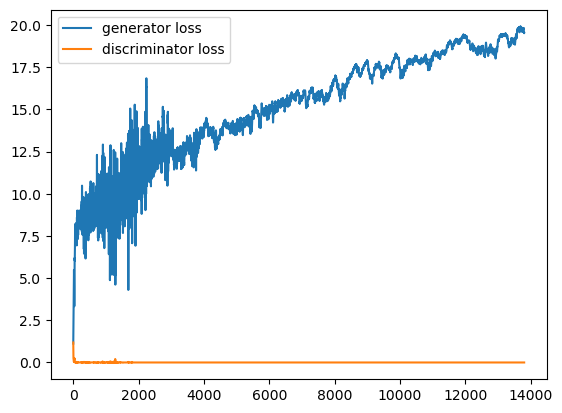

In [55]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

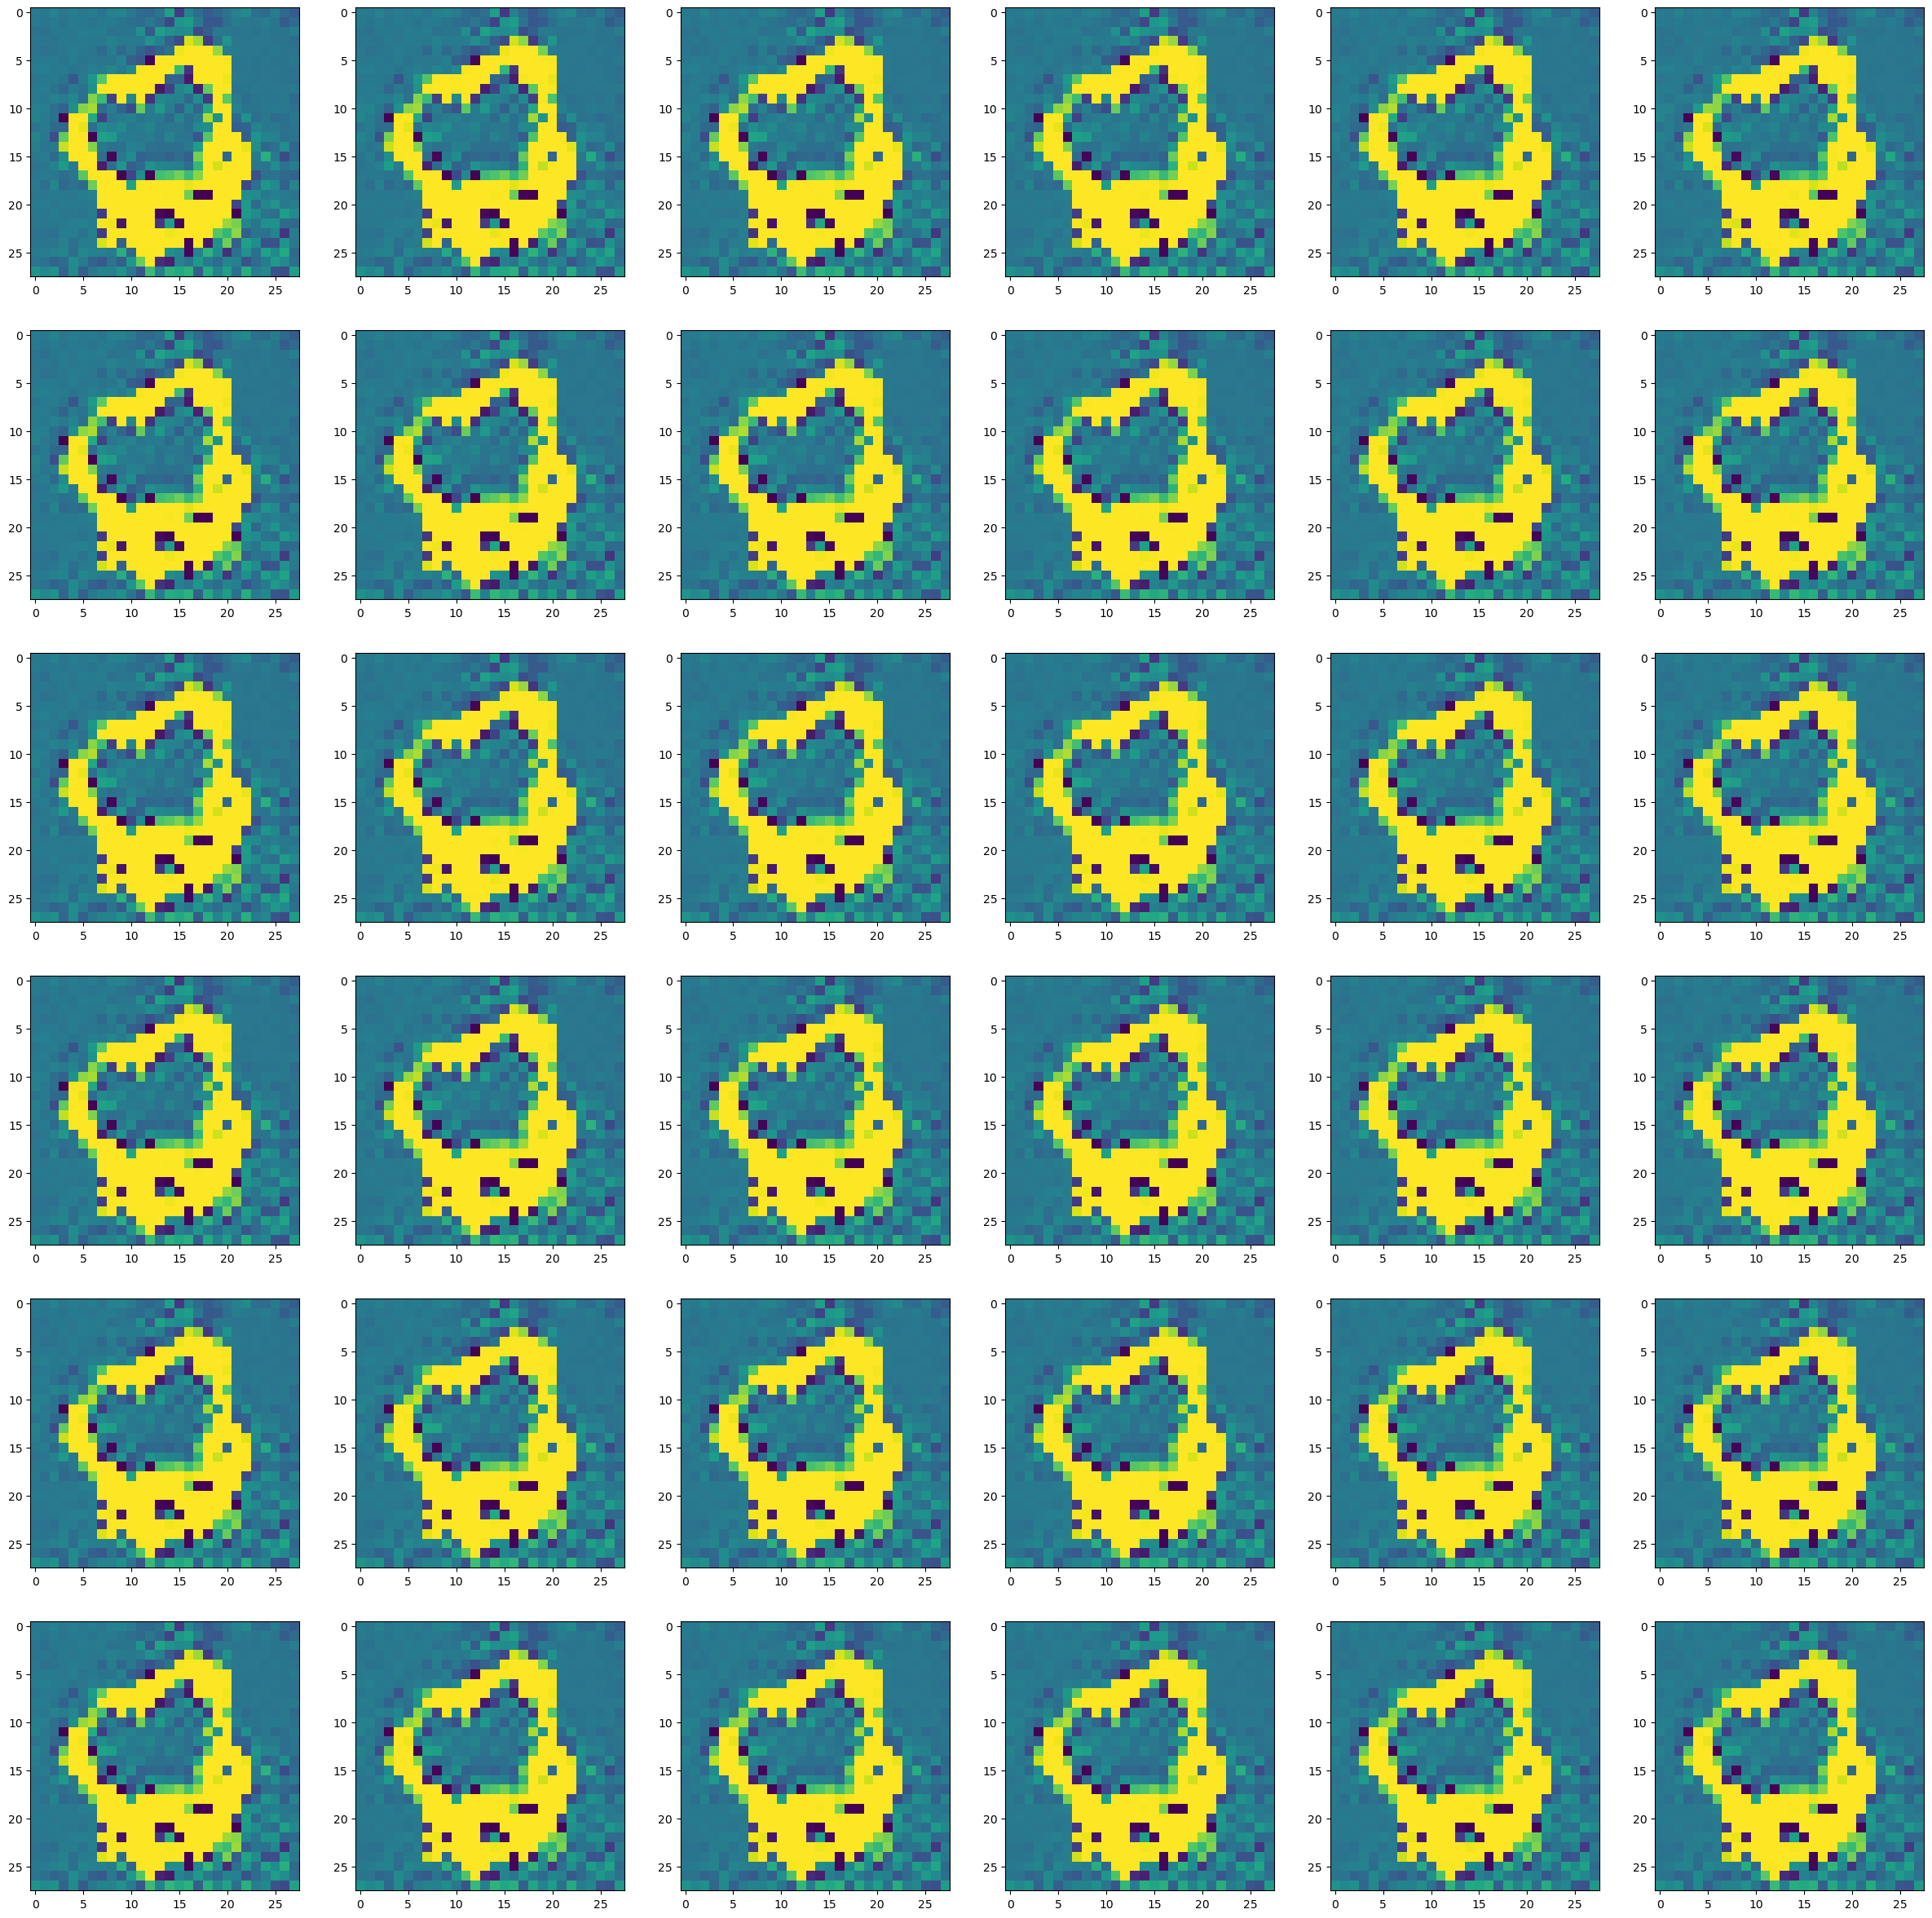

In [56]:
generated = generator(36).detach().to('cpu')

plt.figure(figsize=(30, 30))
for ind, image in enumerate(generated):
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()


In [57]:


!pip install lpips

import lpips
test_fn = lpips.LPIPS(net='vgg')
distances = [] #
# for image in tqdm(zeros_loader):
#   with torch.no_grad():
#     generated = generator(images.shape[0]).detach().to('cpu')
#     for d in test_fn(generated, images.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
#       distances.append(d)

for image in tqdm(zeros_loader):
  with torch.no_grad():
    generated = generator(image[0].shape[0]).detach().to('cpu')
    for d in test_fn(generated, image[0].to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
      distances.append(d)



Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/46 [00:00<?, ?it/s]

In [60]:
# print(np.average(distances))
print(np.average(distances))
print(distances)

0.338765047553866
[0.36192095279693604, 0.31193673610687256, 0.36558055877685547, 0.3356975317001343, 0.2986469268798828, 0.29546257853507996, 0.3420121669769287, 0.3364379405975342, 0.3438582420349121, 0.38974541425704956, 0.31429746747016907, 0.3012016713619232, 0.31068697571754456, 0.3094951808452606, 0.28436726331710815, 0.3113441467285156, 0.3435673117637634, 0.3120514750480652, 0.44890296459198, 0.3544806241989136, 0.3019220232963562, 0.29914402961730957, 0.30210256576538086, 0.42702925205230713, 0.32482144236564636, 0.3180287480354309, 0.3705068528652191, 0.31143876910209656, 0.3224063217639923, 0.303517609834671, 0.35650452971458435, 0.2857746183872223, 0.2904050648212433, 0.3579047918319702, 0.3207758665084839, 0.30872079730033875, 0.3178730010986328, 0.4015806019306183, 0.30508413910865784, 0.3214901089668274, 0.2845709025859833, 0.2820764183998108, 0.2749160826206207, 0.41152969002723694, 0.32319849729537964, 0.30416765809059143, 0.30352285504341125, 0.2858458459377289, 0.37

### Conditional GAN
Task: train Conditional GAN in CIFAR10 dataset

In [21]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
cifar_dataset = CIFAR10('./CIFAR10', train=True, transform=image_transforms, download=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=64, drop_last=True)

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


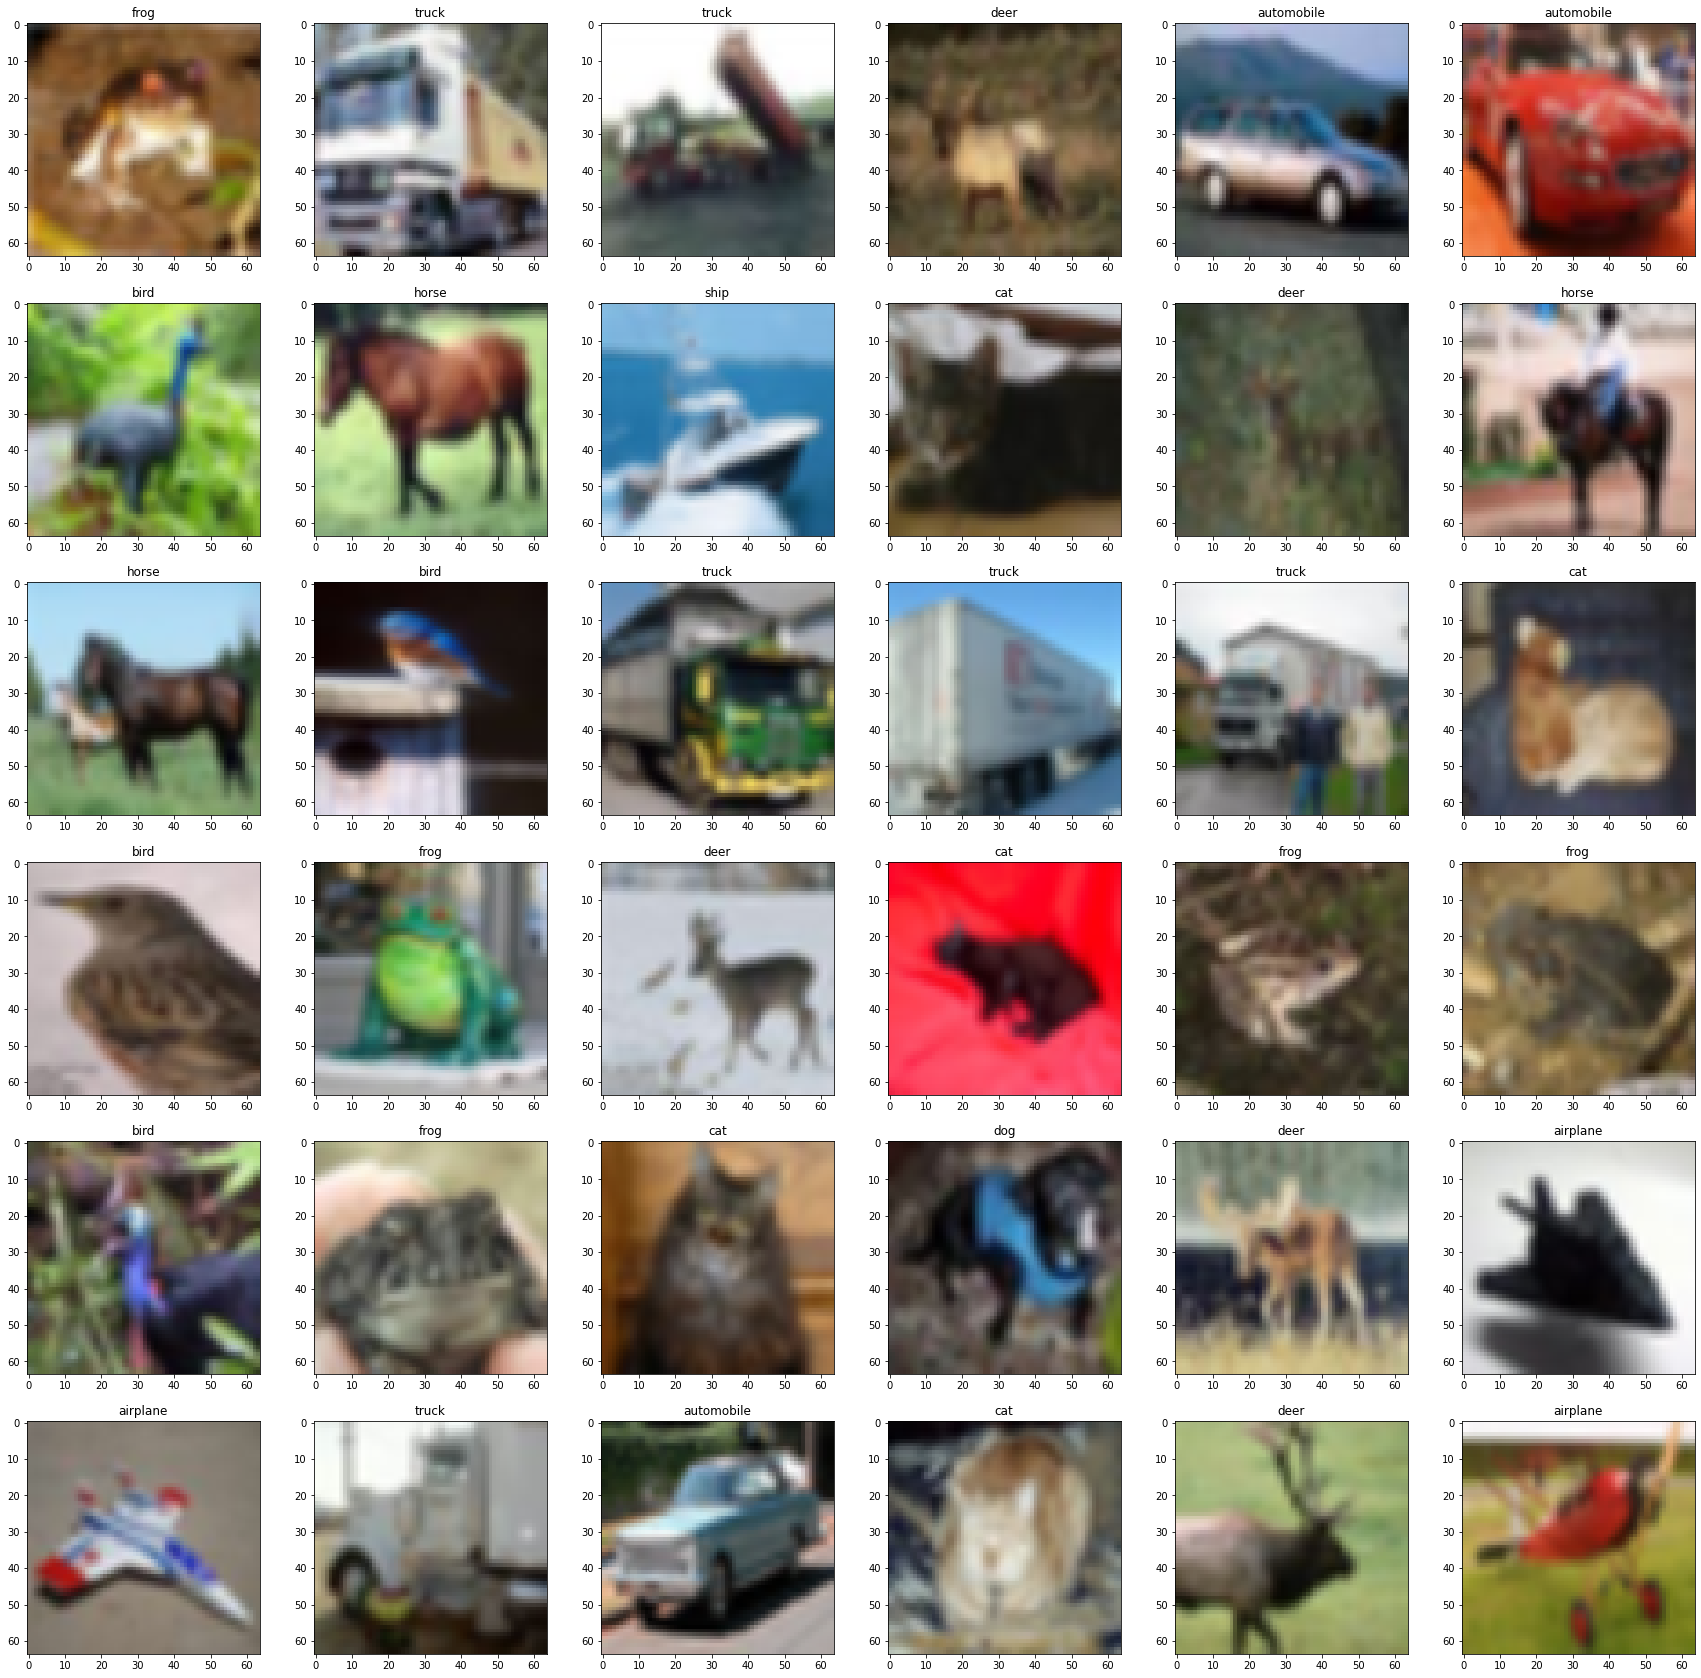

In [22]:
def process_image(image):
    ### YOUR CODE HERE
    return ??? # numpy image with pixel values in [0, 1]


labels2name = {i: j for j, i in cifar_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(cifar_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()

In [53]:
# https://github.com/lt911/Experiment_with_conditional_DCGAN/blob/master/cdcgan.py

class Generator(nn.Module):
    def __init__(self, nc=3, ngf=64, nz=100, embsize=10):
        super(Generator, self).__init__()
        # Define generator which takes random noise with class embeddings of size :param embsize as input and generates image as output
        ??? # YOUR CODE HERE

    def forward(self, c):
        return ??? # YOUR CODE HERE

    @property
    def device(self):
      return next(self.parameters()).device

class Discriminator(nn.Module):
    def __init__(self, ndf=64, ngf=64, nc=3, embsize=10):
        super(Discriminator, self).__init__()
        ??? # YOUR CODE HERE. Define discriminator which takes image with class embeddings as input and returns class (0 for generated images and 1 for real ones)

    def forward(self, input, c):
        ??? # YOUR CODE HERE

In [56]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

n_classes = 10
from sklearn.preprocessing import LabelBinarizer
emb = LabelBinarizer().fit(range(n_classes)) # Label binarizer is used to convert class label to class embeddings

generator = Generator(embsize=n_classes).to(device)
discriminator = Discriminator().to(device)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

[model.apply(weights_init) for model in [generator, discriminator]] # initialize weights

optimizators = {
    'G': torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.9, 0.999)),
    'D': torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.9, 0.999)),
}

losses = {
    'D': [],
    'G': []
}

steps_ratio = 1 # ratio between gradient steps of generator and generator

In [60]:
for epoch in tqdm(range(100)):
    for batch_idx, (images, classes) in enumerate(cifar_loader):
        # train D
        
        ??? # YOUR CODE HERE. Fit discriminator on real and generated images
        
        # Hint: use torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1) # gradient clipping for stable convergence
        
        
        losses['D'].append(loss.item())
        # don't forget to use item
        
        if batch_idx % steps_ratio == 0:
          # train G
          ??? # YOUR CODE HERE. Fit generator to "fool" discriminator (Make the discriminator to classify generated images as real ones)
            # Hint: use torch.nn.utils.clip_grad_norm_(generator.parameters(), 1) # gradient clipping for stable convergence
          
          for _ in range(steps_ratio):
            losses['G'].append(loss.item())

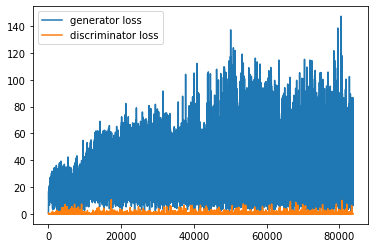

In [61]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

In [ ]:
for batch_idx, (images, labels) in enumerate(cifar_loader):
    images = images.to(device)
    classes = torch.from_numpy(emb.transform(labels.numpy())).type(torch.FloatTensor).view(-1, n_classes, 1, 1).to(device)
    
    batch_size = images.shape[0]
    with torch.no_grad():
      fake_images = generator(classes) # Generate images
    break;

plt.figure(figsize=(30, 30))
for ind in range(fake_images.shape[0]):
    image = fake_images[ind]
    plt.subplot(8, 8, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[labels[ind].item()])
plt.show()

In [68]:


!pip install lpips

import lpips
test_fn = lpips.LPIPS(net='vgg')
distances = [] #
num_test_steps = 50
for batch_idx, (images, labels) in tqdm(enumerate(cifar_loader), total=num_test_steps):
    if batch_idx > num_test_steps: break;
    images = images.to(device)
    classes = torch.from_numpy(emb.transform(labels.numpy())).type(torch.FloatTensor).view(-1, n_classes, 1, 1).to(device)
    
    batch_size = images.shape[0]
    with torch.no_grad():
      generated = generator(classes) # Generate images
    for d in test_fn(generated.to('cpu'), images.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
      distances.append(d)
